<a href="https://colab.research.google.com/github/yesufma/Coordinate/blob/main/Solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade seaborn pandas

In [30]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # For Z-scores

In [32]:
file_path = '/content/drive/MyDrive/benin-malanville.csv'
df = pd.read_csv(file_path)
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [33]:
# Summary statistics for numeric columns
print("Summary Statistics (Numeric Columns Only):")
print(df.describe(include=[np.number]))

# Missing value analysis
missing_values = df.isna().sum()
missing_percent = (missing_values / len(df)) * 100
print("\nMissing Values (Count):\n", missing_values)
print("\nColumns with >5% Missing Values:", missing_percent[missing_percent > 5].index.tolist())

Summary Statistics (Numeric Columns Only):
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.

In [34]:
# Drop 'Comments' column
df_clean = df.drop(columns=['Comments']).copy()  # Use .copy() to avoid warnings

# Clip negative solar values to 0
solar_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
df_clean.loc[:, solar_columns] = df_clean[solar_columns].clip(lower=0)

# Verify no negatives remain
negative_counts = (df_clean[solar_columns] < 0).sum()
print("Negative values after cleaning:\n", negative_counts)

Negative values after cleaning:
 GHI     0
DNI     0
DHI     0
ModA    0
ModB    0
dtype: int64


In [35]:
# Fix wind direction (WD) values (0° ≤ WD < 360°)
df_clean['WD'] = df_clean['WD'] % 360

# Check humidity (RH) values (0% ≤ RH ≤ 100%)
invalid_rh = df_clean[(df_clean['RH'] < 0) | (df_clean['RH'] > 100)]
print(f"Invalid RH values: {len(invalid_rh)}")

Invalid RH values: 0


In [36]:
# Convert to datetime
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

# Check time intervals between readings
time_diff = df_clean['Timestamp'].diff().value_counts()
print("Time intervals between readings:\n", time_diff.head())

Time intervals between readings:
 Timestamp
0 days 00:01:00    525599
Name: count, dtype: int64


In [37]:
# Calculate Z-scores on CLEANED DATA
columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = stats.zscore(df_clean[columns])
outliers = (abs(z_scores) > 3).any(axis=1)

# Remove outliers
df_clean = df_clean[~outliers]
print(f"Removed {outliers.sum()} outliers.")

Removed 7893 outliers.


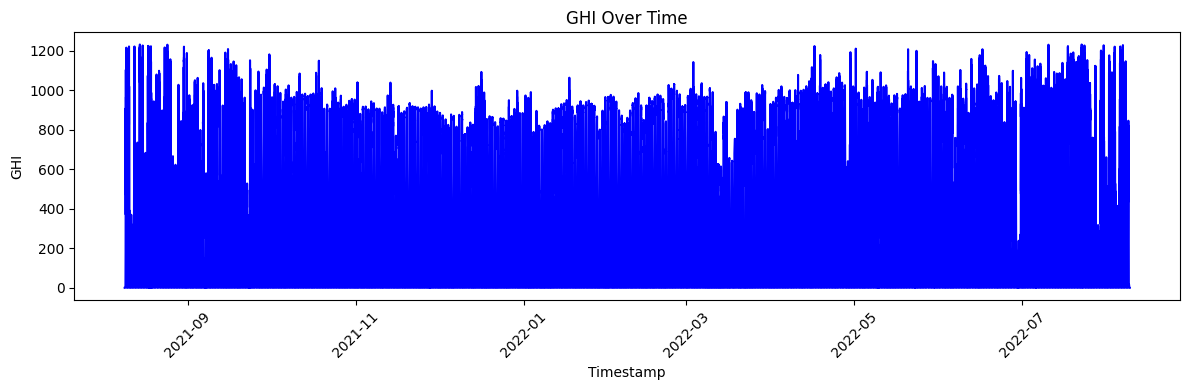

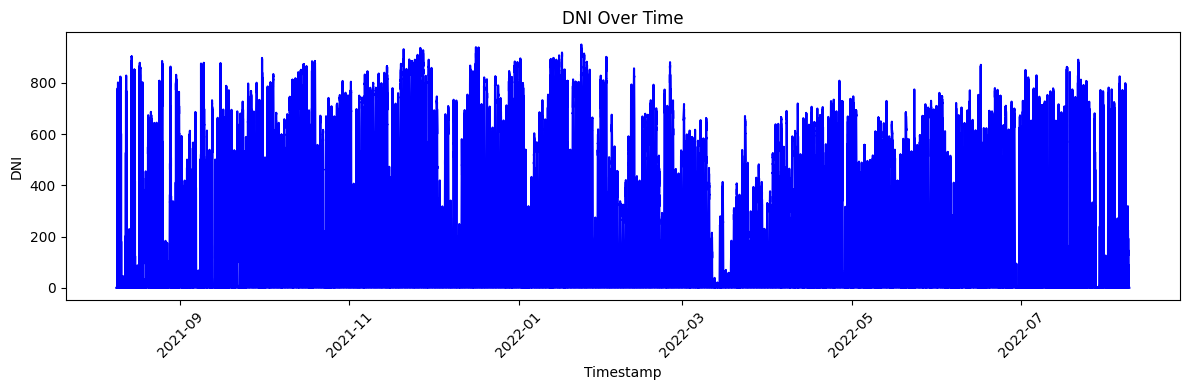

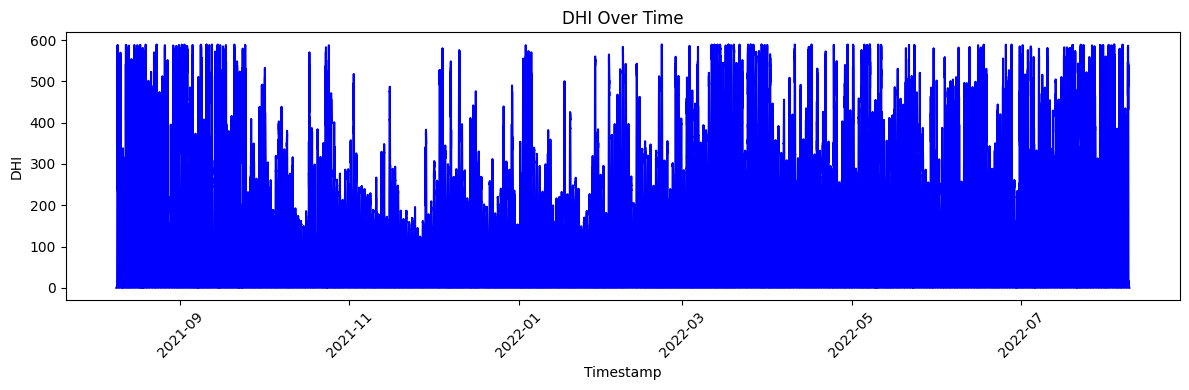

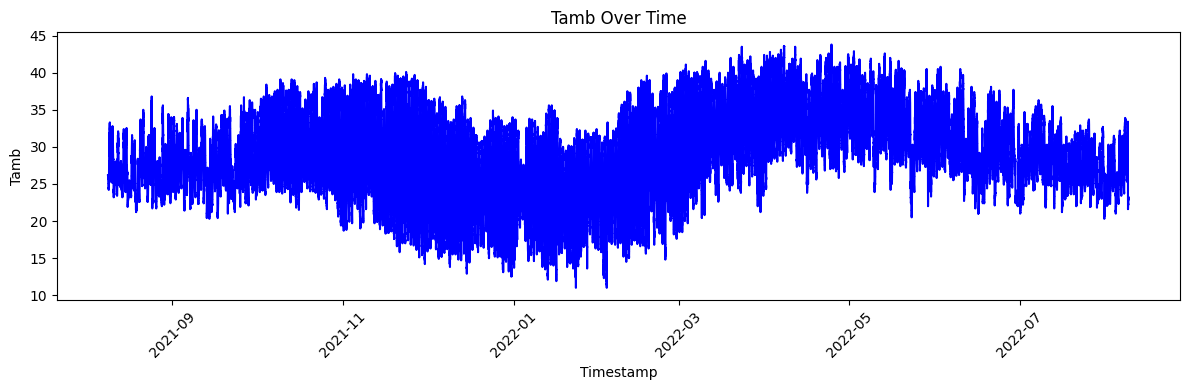

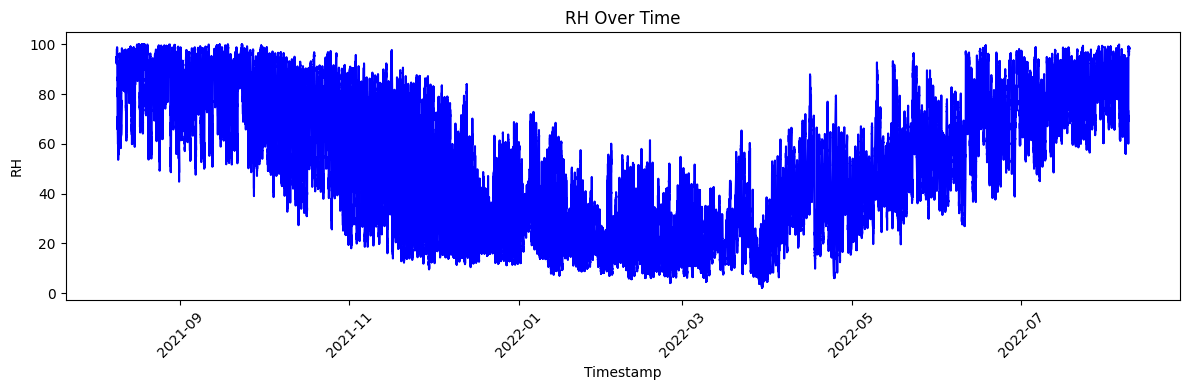

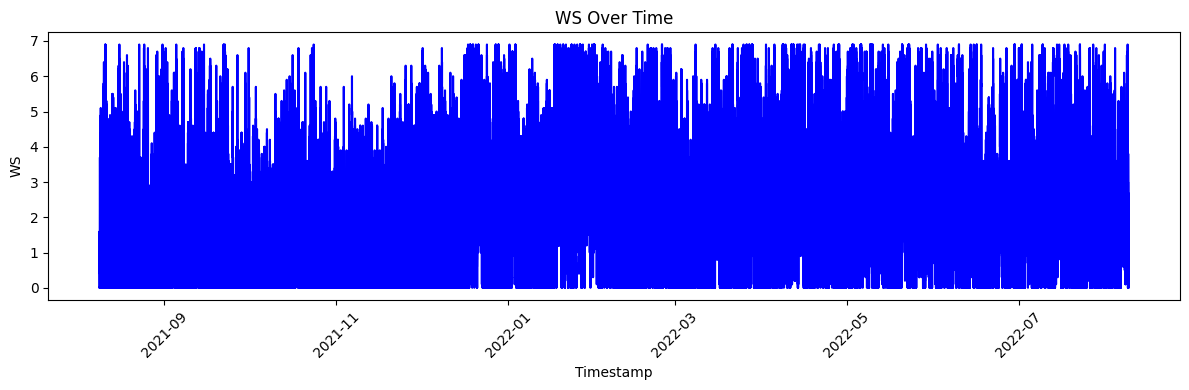

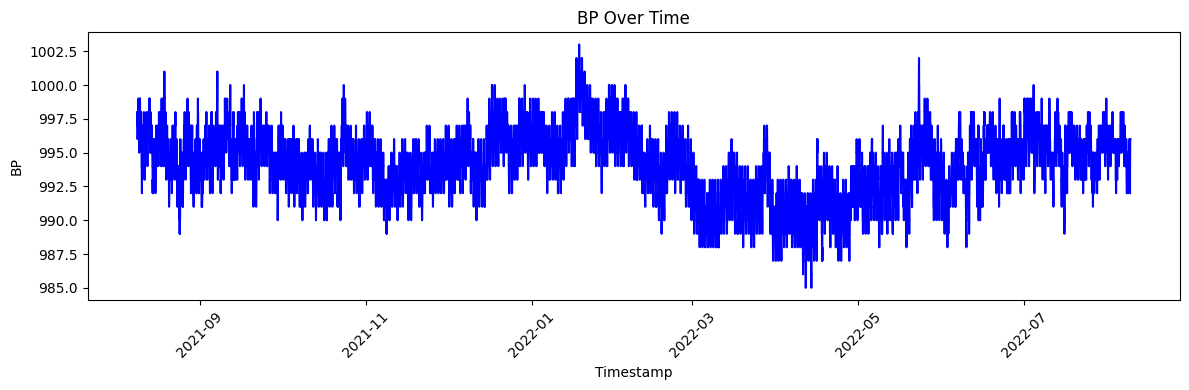

In [38]:
variables = ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS', 'BP']
for var in variables:
    plt.figure(figsize=(12, 4))
    sns.lineplot(x='Timestamp', y=var, data=df_clean, color='blue')
    plt.title(f'{var} Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

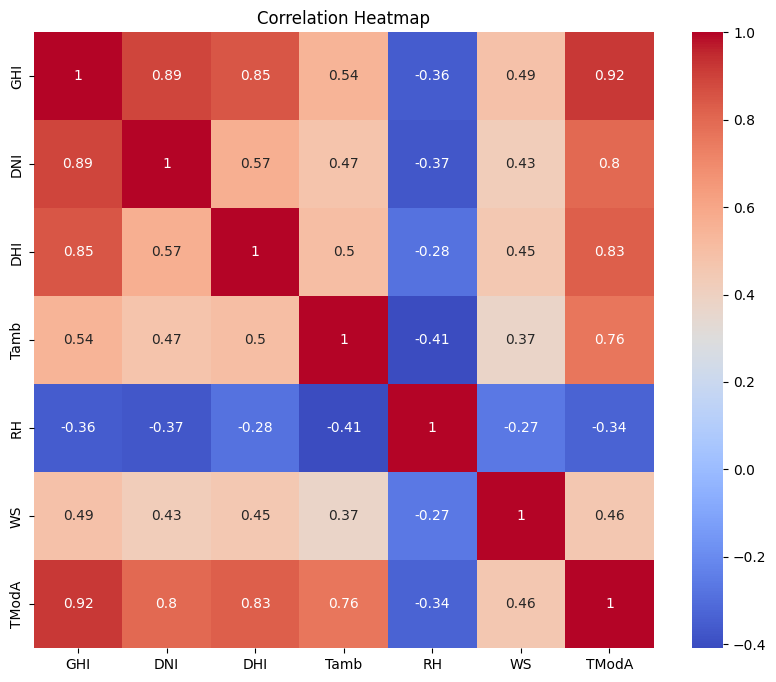

In [39]:
corr_columns = ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS', 'TModA']
corr_matrix = df_clean[corr_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [41]:
# Define variables to analyze (add/remove as needed)
variables = ['ModA', 'ModB', 'TModA', 'TModB', 'GHI', 'Tamb']

# Group by 'Cleaning' flag and compute mean
cleaning_groups = df_clean.groupby('Cleaning')[variables].mean()

# Print tabular results
print("Average Values Before/After Cleaning:")
print(cleaning_groups)

Average Values Before/After Cleaning:
                ModA        ModB      TModA      TModB         GHI       Tamb
Cleaning                                                                     
0         232.172014  224.810702  35.074016  32.364341  237.410742  28.147419
1         306.610124  301.450000  40.341529  35.363017  316.381405  26.227066


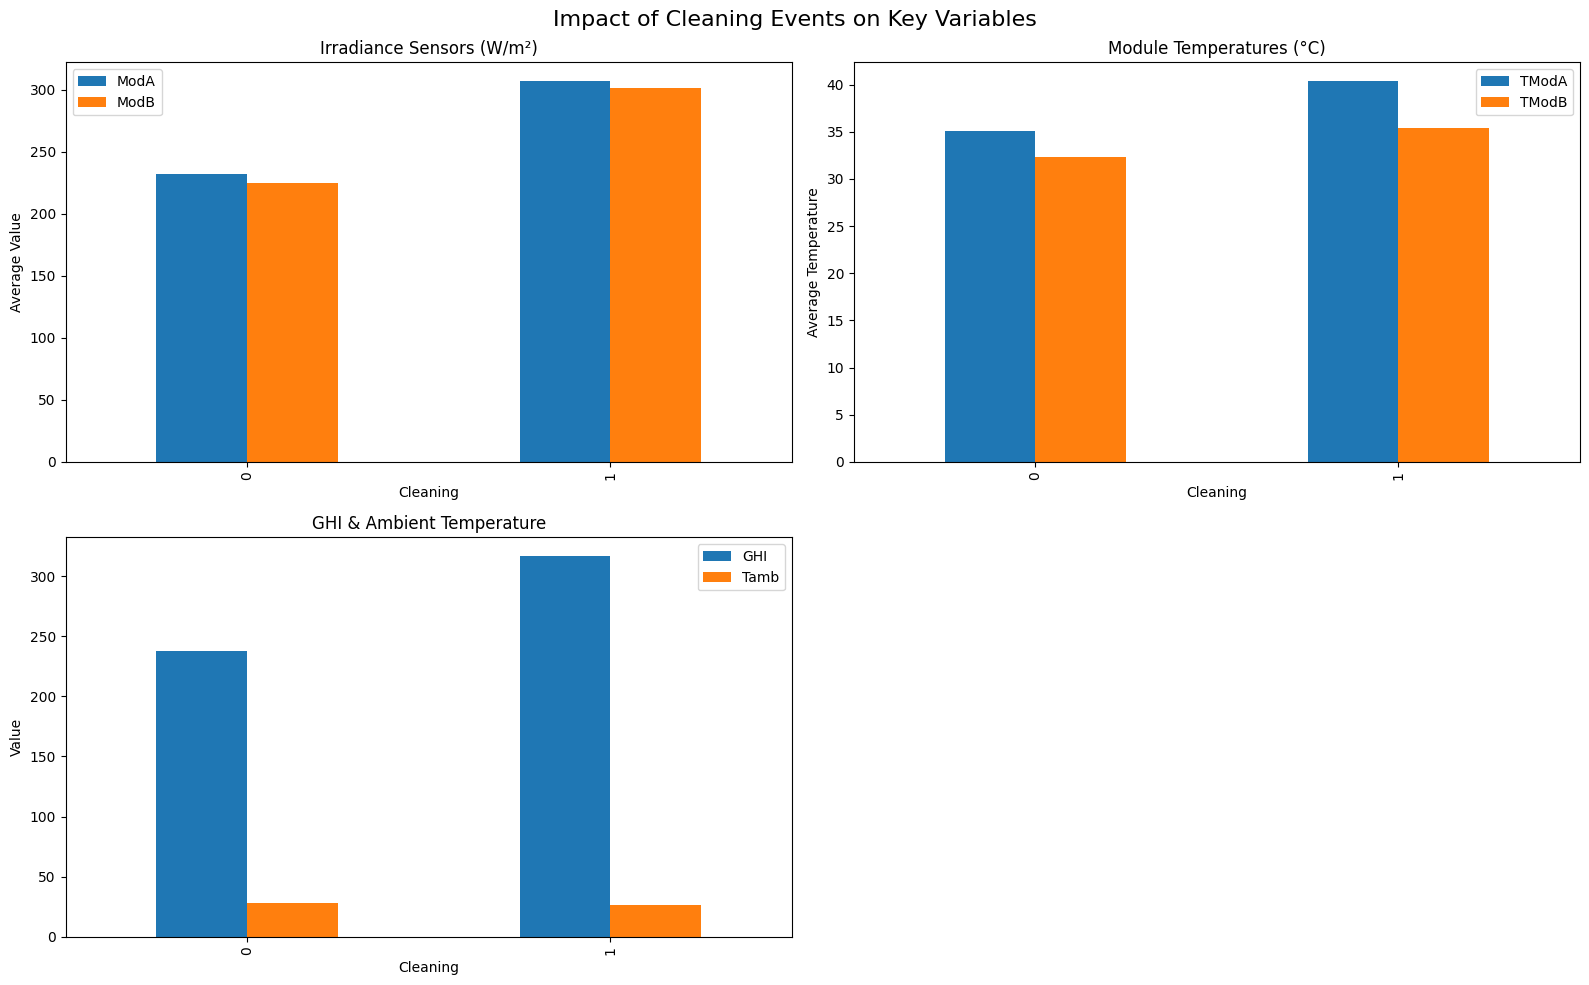

In [42]:
# subplots for better readability
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Impact of Cleaning Events on Key Variables', fontsize=16)

# Plot 1: Sensor Readings (ModA, ModB)
cleaning_groups[['ModA', 'ModB']].plot(
    kind='bar',
    ax=axes[0, 0],
    title='Irradiance Sensors (W/m²)',
    ylabel='Average Value'
)

# Plot 2: Module Temperatures (TModA, TModB)
cleaning_groups[['TModA', 'TModB']].plot(
    kind='bar',
    ax=axes[0, 1],
    title='Module Temperatures (°C)',
    ylabel='Average Temperature'
)

# Plot 3: GHI and Ambient Temperature
cleaning_groups[['GHI', 'Tamb']].plot(
    kind='bar',
    ax=axes[1, 0],
    title='GHI & Ambient Temperature',
    ylabel='Value'
)

# Plot 4: Empty subplot (or add more variables)
axes[1, 1].axis('off')  # Remove unused subplot

plt.tight_layout()
plt.show()

In [43]:
import os

# Define and create the directory
drive_path = "/content/drive/MyDrive/Solar Project/data"
os.makedirs(drive_path, exist_ok=True)  # Create folder if it doesn’t exist

# Save the cleaned data
csv_path = os.path.join(drive_path, "benin_clean.csv")
df_clean.to_csv(csv_path, index=False)
print(f"File saved to Google Drive: {csv_path}")

File saved to Google Drive: /content/drive/MyDrive/Solar Project/data/benin_clean.csv
